In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
inspector = inspect(engine)
tables = inspector.get_table_names()
# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)
measurement = Base.classes.measurement
station = Base.classes.station

In [7]:
tables

['measurement', 'station']

In [8]:
# We can view all of the classes that automap found
measurement_columns = inspector.get_columns('measurement')
station_columns = inspector.get_columns('station')

for c in measurement_columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
for c in station_columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Save references to each table
me = Base.classes.measurement
st = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
engine.execute('SELECT * FROM measurement ORDER BY ID DESC LIMIT 5').fetchall()

[(19550, 'USC00516128', '2017-08-23', 0.45, 76.0),
 (19549, 'USC00516128', '2017-08-22', 0.5, 76.0),
 (19548, 'USC00516128', '2017-08-21', 0.56, 76.0),
 (19547, 'USC00516128', '2017-08-20', None, 78.0),
 (19546, 'USC00516128', '2017-08-19', 0.09, 71.0)]

# Exploratory Climate Analysis

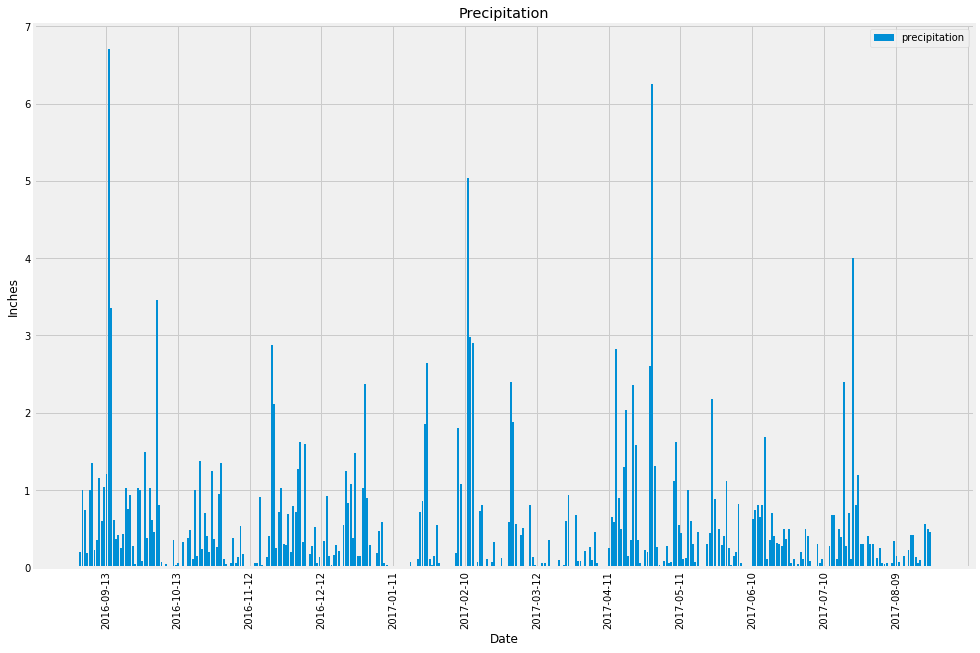

In [13]:
# Designing a query to retrieve the last 12 months of precipitation data and plot the results
# Calculating the date 1 year ago from the last data point in the database
engine.execute('SELECT * FROM measurement ORDER BY ID DESC LIMIT 5').fetchall()
# Performing a query to retrieve the data and precipitation scores
year = '2016-09-01'
last_year_pre = session.query(me.date,me.prcp).filter(func.strftime('%Y-%m-%d', me.date) >= year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_pre_df = pd.DataFrame(last_year_pre)

# Sorting the dataframe by date
last_year_pre_df = last_year_pre_df.sort_values(by=['date'])
last_year_pre_df.to_json('Resources/Last_Year_Measurement.json', orient="records")

# Using Pandas Plotting with Matplotlib to plot the data
x = last_year_pre_df['date']
y = last_year_pre_df['prcp']

fig, ax = plt.subplots(figsize=(15,10))
ax.bar(x,y,label = 'precipitation')
start, end = ax.get_xlim()
plt.xticks(np.arange(start,end, step=30))
plt.xticks(rotation=90)
plt.title('Precipitation')
plt.legend()
plt.ylabel('Inches')
plt.xlabel('Date')
plt.show()

In [14]:
# Using Pandas to calcualte the summary statistics for the precipitation data
last_year_pre_df.describe()

,prcp
count,1968.000000
mean,0.171479
std,0.451817
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [16]:
# Designing a query to show how many stations are available in this dataset?
engine.execute('SELECT * FROM station LIMIT 5').fetchall()
total_stations = session.query(st).distinct(st.station).group_by(st.station).count()
stations_all = session.query(st.station,st.name,st.latitude,st.longitude,st.elevation).all()
stations_df = pd.DataFrame(stations_all)
stations_df = stations_df.set_index('station')
stations_df.to_json('Resources/stations.json', orient="records")
total_stations

9

In [17]:
# Showing the most active stations
# Listing the stations and the counts in descending order.
act_stations = session.query(me.station, func.count(me.station)).group_by(me.station).order_by(func.count(me.station).desc()).all()
display(act_stations)
name = session.query(st.name).filter(st.station == act_stations[0][0]).all()
print(f'The station "{name[0][0]}" has the highest number of observations')

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

The station "WAIHEE 837.5, HI US" has the highest number of observations


In [18]:
# Using the station id from the previous query
# Calculating the lowest temperature recorded, highest temperature recorded, and average temperature of the most active station
sel = [func.min(me.tobs), 
       func.max(me.tobs), 
       func.avg(me.tobs)]

act_sta_stats = session.query(*sel).filter(me.station == act_stations[0][0]).all()

print(f'The lowest temperature recorded for the station "{name[0][0]}" is: {act_sta_stats[0][0]}')
print(f'The highest temperature recorded for the station "{name[0][0]}" is: {act_sta_stats[0][1]}')
print(f'The average temperature for the station "{name[0][0]}" is: {round(act_sta_stats[0][2],2)}')

The lowest temperature recorded for the station "WAIHEE 837.5, HI US" is: 54.0
The highest temperature recorded for the station "WAIHEE 837.5, HI US" is: 85.0
The average temperature for the station "WAIHEE 837.5, HI US" is: 71.66


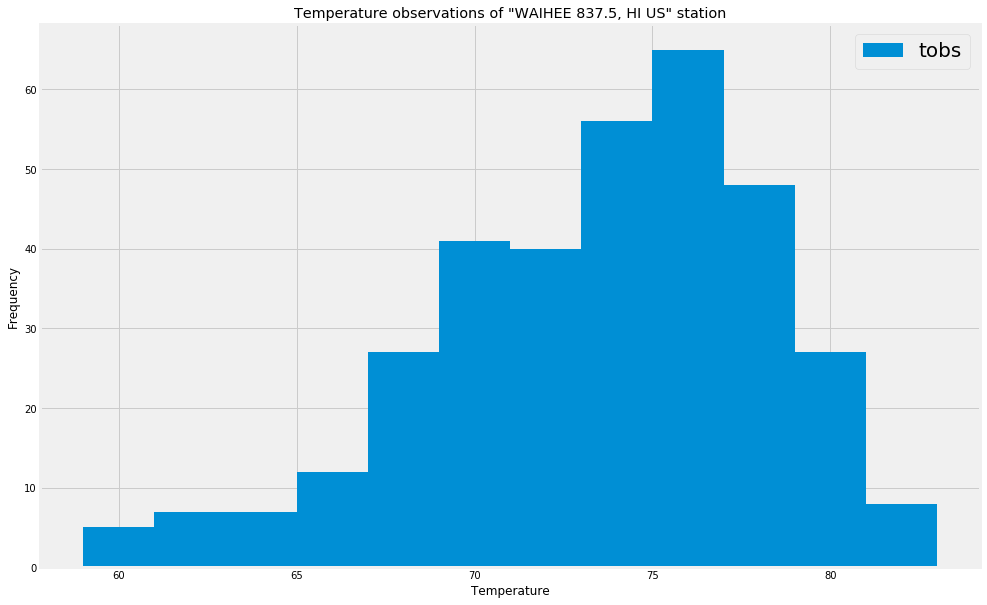

In [19]:
# Choosing the station with the highest number of temperature observations.
# Making a query for the last 12 months of temperature observation data for this station
temp_obs_higher1 = session.query(me.date,me.tobs).filter(func.strftime('%Y-%m-%d', me.date) >= year, me.station == act_stations[0][0]).all()
temp_obs_higher = session.query(me.tobs).filter(func.strftime('%Y-%m-%d', me.date) >= year, me.station == act_stations[0][0]).all()
temp_obs_higher_df = pd.DataFrame(temp_obs_higher1)
temp_obs_higher_df.set_index('date').sort_values(by=['date'])
temp_obs_higher_df.to_json('Resources/Higher_temb_obs.json', orient="records")
temp_obs_list = [num for t in temp_obs_higher for num in t] 
plt.figure(figsize=(15,10))
plt.hist(temp_obs_list, bins=12)
plt.title(f'Temperature observations of "{name[0][0]}" station')
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.legend(['tobs'],prop={'size': 20})
#Ploting the results as a histogram
plt.show()
